In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk
from tqdm import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm

In [36]:
df=pd.read_csv('E:/SE/dataset/Less_reviews.csv') 

In [37]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [38]:
example=df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [39]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Download tokenizer and model if not downloaded already
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Save the tokenizer and model to disk
tokenizer.save_pretrained("tokenizer_cache")
model.save_pretrained("model_cache")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
# Load the tokenizer and model from the local cache
tokenizer = AutoTokenizer.from_pretrained("tokenizer_cache")
model = AutoModelForSequenceClassification.from_pretrained("model_cache")


In [41]:
df=df.head(100)

In [42]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)

{'roberta_neg': 0.9535124, 'roberta_neu': 0.040926386, 'roberta_pos': 0.0055612493}


In [43]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores = scores
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict 

In [44]:
res={}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)        
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/100 [00:00<?, ?it/s]

Broke for id 83


In [45]:
roberta_df = pd.DataFrame(res).T
roberta_df = roberta_df.reset_index().rename(columns={'index':'Id'})
roberta_df = roberta_df.merge(df, how='left')

In [58]:
# Initialize lists to store data
data = {'Id': [], 'r_neg': [], 'r_pos': [], 'r_neu': [], 'Rating': []}

for i, row in tqdm(roberta_df.iterrows(), total=len(roberta_df)):
    r_neg = roberta_df['roberta_neg'][i]
    r_pos = roberta_df['roberta_pos'][i]
    r_neu = roberta_df['roberta_neu'][i]
    
    if r_neg >= 0.85:
        rating = 1
    elif r_pos >= 0.85:
        rating = 5
    elif 0.65 <= r_pos < 0.85:
        rating = 4
    elif 0.65 <= r_neg < 0.85:
        rating = 2
    else:
        rating = 3
    
    my_id = row['Id']  # Extract 'Id' from the current row
    
    # Append data to lists
    data['Id'].append(my_id)
    data['r_neg'].append(r_neg)
    data['r_pos'].append(r_pos)
    data['r_neu'].append(r_neu)
    data['Rating'].append(rating)  

# Create a DataFrame from the collected data
max_df = pd.DataFrame(data)

# Display the resulting DataFrame
print(max_df)

  0%|          | 0/99 [00:00<?, ?it/s]

     Id     r_neg     r_pos     r_neu  Rating
0     1  0.010578  0.950607  0.038816       5
1     2  0.716768  0.012007  0.271225       2
2     3  0.005176  0.916966  0.077858       5
3     4  0.002919  0.949957  0.047125       5
4     5  0.004527  0.986190  0.009283       5
..  ...       ...       ...       ...     ...
94   96  0.025002  0.850649  0.124349       5
95   97  0.007137  0.931264  0.061599       5
96   98  0.393674  0.273822  0.332504       3
97   99  0.192269  0.146495  0.661236       3
98  100  0.944782  0.008351  0.046867       1

[99 rows x 5 columns]


In [65]:
# Merge DataFrames on index
display_df = pd.merge(max_df, roberta_df, left_index=False, right_index=False, how='inner')

# List of unwanted columns in df1
unwanted_columns_merged = ['r_neg', 'r_pos', 'r_neu',
                           'roberta_neg', 'roberta_pos', 'roberta_neu',
                           'Time', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
                           'UserId', 'ProductId', 'ProfileName']

# Drop unwanted columns from df1
display_df = display_df.drop(unwanted_columns_merged, axis=1)

column_order = ['Id', 'Rating', 'Score', 'Summary', 'Text']

display_df=display_df[column_order]

# Display the resulting DataFrame with selected columns
print(display_df)

     Id  Rating  Score                                         Summary  \
0     1       5      5                           Good Quality Dog Food   
1     2       2      1                               Not as Advertised   
2     3       5      4                           "Delight" says it all   
3     4       5      2                                  Cough Medicine   
4     5       5      5                                     Great taffy   
..  ...     ...    ...                                             ...   
94   96       5      5                           Good healthy dog food   
95   97       5      5                                  Great dog food   
96   98       3      5  Great allergy sensitive dog food, dogs love it   
97   99       3      5  Perfect for our English Bulldog with Allergies   
98  100       1      1                                             Bad   

                                                 Text  
0   I have bought several of the Vitality canned d...  

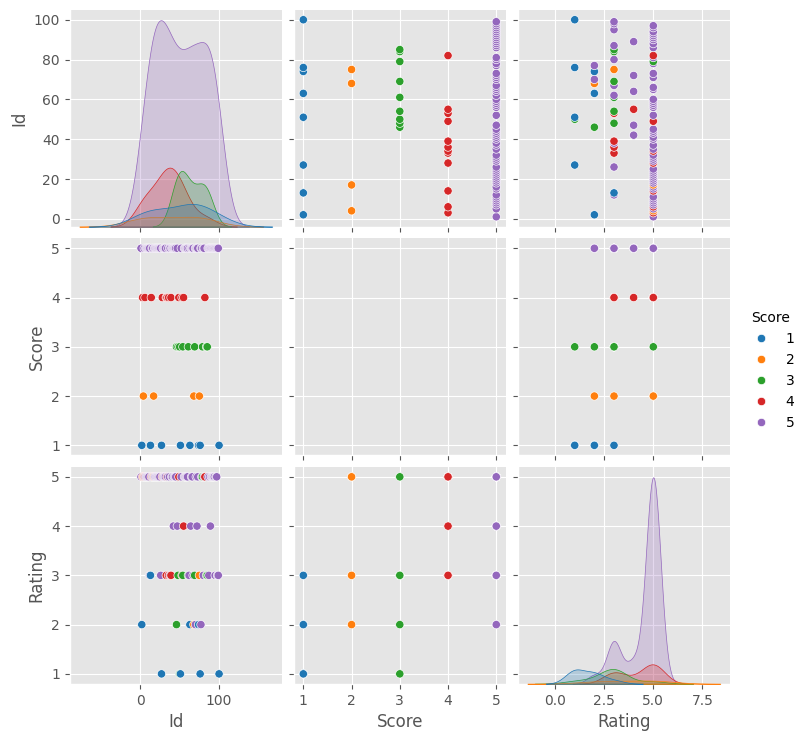

In [64]:
sns.pairplot(data=display_df,
             vars=['Id','Score','Rating'],
             hue='Score',
             palette='tab10')
plt.show()